In [1]:
import kwant
import tinyarray
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
## GLOBAL DEFINITIONS:
lat = kwant.lattice.honeycomb(a=1, norbs=2)
A, B = lat.sublattices

zeros_2x2 = tinyarray.array([[0,0],[0,0]])
sigma_0 = tinyarray.array([[1,0],[0,1]])
sigma_x = tinyarray.array([[0,1],[1,0]])
sigma_y = tinyarray.array([[0,-1j],[1j,0]])
sigma_z = tinyarray.array([[1,0],[0,-1]])

In [3]:
class Rectangle:
    def __init__(self, W, L):
        self.W = W
        self.L = L
    def __call__(self, pos):
        """
        Define the scattering region's shape.
        """
        W, L = self.W, self.L
        x, y = pos
        return 0 < y <= W and 0 <= x < L

class LeadShape:
    def __init__(self, W):
        self.W = W
    def __call__(self, pos):
        y = pos[1]
        return 0 < y <= self.W

In [4]:
def make_syst_and_leads(W=4.5, L=20, V=0, t=1, phi=0):
    syst = make_graphene_strip_PBC(W, L, V, t, phi)
    leads = make_graphene_leads_PBC(W, V, t, phi)
    return syst, leads

def make_graphene_strip_PBC(W, L, V, t, phi):
    # DEFINING THE SYSTEM'S SHAPE
    W_new, N = W_to_close(W)
    rectangle = Rectangle(W_new, L)

    syst = kwant.Builder()
    syst[lat.shape(rectangle, (0, 0))] = V * sigma_0
    syst[lat.neighbors()] = -t * sigma_0

    sites_x_tags = [s.tag[0] for s in syst.sites() if s.family == B]
    M = max(sites_x_tags) + 1

    for i in range(M):
        syst[A(i-N, 2*N), B(i, 0)] = -t * np.exp(-1j*phi) * sigma_0

    return syst

def make_graphene_leads_PBC(W, V, t, phi):
    W_new, N = W_to_close(W)
    lead_shape = LeadShape(W_new)

    symmetry = kwant.TranslationalSymmetry((-1,0))
    symmetry.add_site_family(lat.sublattices[0], other_vectors=[(-1,2)])
    symmetry.add_site_family(lat.sublattices[1], other_vectors=[(-1,2)])

    lead_0 = kwant.Builder(symmetry)
    lead_0[lat.shape(lead_shape, (0,0))] = V * sigma_0
    lead_0[lat.neighbors()] = -t * sigma_0

    lead_0[A(-N, 2*N), B(0, 0)] = -t * np.exp(-1j*phi) * sigma_0
    lead_1 = lead_0.reversed()
    return [lead_0, lead_1]

def W_to_close(W):
    N = max(W // np.sqrt(3), 2)
    return N * np.sqrt(3), int(N)

def assemble_syst(syst, leads):
    for lead in leads:
        syst.attach_lead(lead)
    return syst

In [97]:
def calculate_DOS(fsystem):
    spectrum = kwant.kpm.SpectralDensity(fsystem)
    spectrum.add_moments(200)

#     spectrum.add_moments(energy_resolution=0.01)
    spectrum.add_vectors(500)
    energies, densities = spectrum()
    return energies, densities

def plot_DOS(fsystem):
    energies, densities = calculate_DOS(fsystem)
    figure, ax = plt.subplots(figsize=(7,5))
    # ax.plot(energies, densities.real)
    ax.plot(energies, densities.real, lw=2)
    ax.set_xlim(-4,4)
#     ax.set_ylim(-0.4,0.4)
    ax.set_xlabel('Energy [eV]')
    ax.set_ylabel('DOS [a.u.]')
    plt.tight_layout()
    plt.show()

In [71]:
def calculate_LDOS(fsyst, Energy):
    kwant_op = kwant.operator.Density(fsyst, sum=False)
    local_dos = kwant.kpm.SpectralDensity(fsyst, operator=kwant_op)
    local_dos.add_vectors(100)
    zero_energy_ldos = local_dos(energy=0)
    finite_energy_ldos = local_dos(energy=Energy)
    return zero_energy_ldos, finite_energy_ldos

In [72]:
def family_colors(site):
    if site.family == A:
        color = 'k'
    elif site.family == B:
        color = 'w'
    elif site.family == HA:
        color = 'magenta'
    elif site.family == HB:
        color = 'magenta'
    else:
        color = 'magenta'
    return color

In [76]:
system, leads = make_syst_and_leads(W=20, L=20, t=2.6, phi=0)
system_completed = assemble_syst(system, leads)

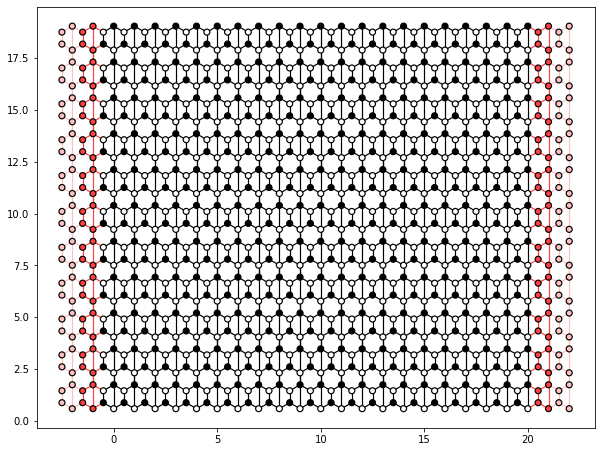

In [77]:
fig, ax = plt.subplots(figsize=(10,10))
ax.set_aspect('equal')
kwant.plot(system_completed, site_color=family_colors, site_lw=0.1, ax=ax);

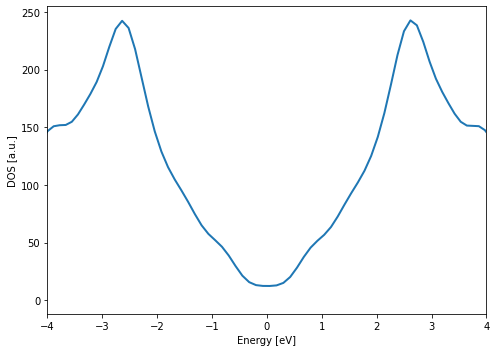

In [78]:
fsyst_wo_adatom = system_completed.finalized()
plot_DOS(fsyst_wo_adatom)

## Inserting the adatom

In [79]:
hydrogen = kwant.lattice.honeycomb(a=1, 
                                   norbs = 2, # number of orbitals per site (spin)
                                   name='H'   # name for identification
                                  )
## Split in sublattices
HA, HB = hydrogen.sublattices

In [80]:
## Getting the neighboring sites
def get_neighbors(system, C_H_site):
    site_tag = C_H_site.tag
    site_sub = C_H_site.family
    nn_list = get_nn(system, site_tag, site_sub)
    nnn_list = get_nnn(system, site_tag, site_sub)
    return nn_list, nnn_list

def get_nn(system, tag, sub_s):
    """
    system := kwant.builder.Builder
    tag    := tuple (i,j) of the site's tag
    sub_s  := site's sublattice

    Notice that
    """
    list_sub_lat = [A, B]
    list_sub_lat.remove(sub_s)
    sub_nn, = list_sub_lat
    # print(sub_nn.name[-1])
    name_indx = int(sub_s.name[-1])
    delta = +1 if name_indx == 0 else -1
    i,j = tag
    nn_tag_list = [(i,j), (i+delta,j-delta), (i,j-delta)]
    nn_sites = [
        sub_nn(*t) for t in nn_tag_list if sub_nn(*t) in system
    ]
    return nn_sites

def get_nnn(system, tag, sub_s):
    """
    system := kwant.builder.Builder
    tag    := tuple (i,j) of the site's tag
    sub_s  := site's sublattice

    Notice that
    """
    #sub_nnn = sub_s

    i,j = tag
    nnn_tag_list = [(  i,j+1), (i+1,  j),
                    (i+1,j-1), (  i,j-1),
                    (i-1,  j), (i-1,j+1)]
    nnn_sites = [
        sub_s(*t) for t in nnn_tag_list if sub_s(*t) in system
    ]
#     for site in nnn_sites:
#         print(site)
    return nnn_sites

In [81]:
## Changing the hoppings around the adatom
def include_ASO_sitewise(system, CH_site, NNN_site, Lambda_I=1):
    """
    Define and replace the hopping between CH_site and one of its NNN sites,
    which is identified here as NNN_site.
    """
    # 1.1. Identify the hopping 1/2
    delta_tag = list(NNN_site.tag - CH_site.tag)
    if delta_tag in ([0,1], [1,-1], [-1,0]): sign = -1
    else: sign = +1

    # 1.2. Identify the hopping 2/2
    family_id  = 1 - 2 * int(CH_site.family.name[-1]) ## 1 (-1) if sublattice == A (B)

    # 3. Define the hopping
    H_asoc_matrix = family_id * 1j/3 * Lambda_I/np.sqrt(3) * sigma_z # clockwise
#     H_asoc = HoppingFunction(B_0_hopping=H_asoc_matrix, sign=sign)
    
    system[CH_site, NNN_site] = sign * H_asoc_matrix

def include_BR_sitewise(system, CH_site, NN_site, t=1, Lambda_BR=1):
    """
    Update the hopping between the CH_site and the NN_site to include
    the Bychkov-Rashba SOC.
    """
    # 1. Identify the hopping 2/2:
    dx, dy = np.sqrt(3) * (CH_site.pos - NN_site.pos)
    
    
    
    H_hop_matrix = t * sigma_0
    H_BR_matrix = (2j/3) * Lambda_BR * (dy * sigma_x - dx * sigma_y) ## (S X d_ij)_z
    
    H_matrix = H_hop_matrix + H_BR_matrix
    
#     H_BR = HoppingFunction(B_0_hopping = H_matrix, sign=+1)
    
    
    # 2. Define the hopping
    system[CH_site, NN_site] = H_matrix

def include_PIA_sitewise(system, site_target, site_source, Lambda_PIA=1):
    """
    Define the PIA hopping and add to the already existent hopping between
    site_target and site_source.
    """
    # 1.1 Identify the hopping 1/2:
    Dx, Dy = site_target.pos - site_source.pos
    
    # 1.2 Identify the hopping 2/2:
    delta_tag = site_target.tag - site_source.tag
    
    # 2. ISO
#     sites_family = site_target.family
#     if sites_family == A and delta_tag in ([0,1], [1,-1], [-1,0]):
#         H_iso_matrix = 1j/3 * lambda_I/np.sqrt(3) * sigma_z
#     elif sites_family == B and delta_tag in ([0,-1], [-1,+1], [1,0]):
#         H_iso_matrix = 1j/3 * lambda_I/np.sqrt(3) * sigma_z
#     else:
#         H_iso_matrix = -1j/3 * lambda_I/np.sqrt(3) * sigma_z

    # 3. PIA:
    H_PIA_matrix =  2j/3 * Lambda_PIA * (Dy * sigma_x - Dx * sigma_y) ## (S x D_ij)_z
    
    # 4. Total hopping:
#     H_PIA_ISO = HoppingFunction(B_0_hopping = (H_iso_matrix + H_PIA_matrix), sign=+1) 
    
    system[site_target, site_source] = H_PIA_matrix

In [82]:
## Inserting adatom:
def insert_adatom(syst, pos_tag, sub_lat, V=0, t=1, l_iso=1, T=1, L_I=1, L_BR=1, L_PIA=1):
    if sub_lat == A:
        site_CH = A(*pos_tag)
        site_H = HA(*pos_tag)
    elif sub_lat == B:
        site_CH = B(*pos_tag)
        site_H = HB(*pos_tag)

    ## On-site:
    # syst[site_H] = on_site_H_with_Zeeman
    syst[site_H] = V * sigma_0
    
    ## Hopping:
    syst[site_H, site_CH] = T * sigma_0
    
    ## Neighbors
    nn_sites, nnn_sites = get_neighbors(syst, site_CH)

    ## Calculate and include the Adatom induced spin-orbit coupling
    for site in nnn_sites:
        include_ASO_sitewise(syst, site_CH, site, Lambda_I=L_I)

    ## Calculate and include into the system the Bychkov-Rashba spin-orbit coupling (BR)
    for site in nn_sites:
        include_BR_sitewise(syst, site_CH, site,t=t, Lambda_BR=L_BR)

    ## Calculate and include into the system the Pseudo-spin inversion asymmetry spin-orbit coupling (PIA)
    targets = [nn_sites[(i+1)%3] for i in range(3)]
    for site1, site2 in zip(targets, nn_sites):
        include_PIA_sitewise(syst, site1, site2, Lambda_PIA=L_PIA)

In [83]:
pos_tag = (4,12)  # tag for the adatom
sub_lat = A      # sublattice of adatom
adatom_params = dict(V=0.16, t=2.6, T=7.5, L_I=-0.21e-3, L_BR=0.33e-3, L_PIA=-0.77e-3)

In [84]:
insert_adatom(system_completed, pos_tag, sub_lat,  **adatom_params)

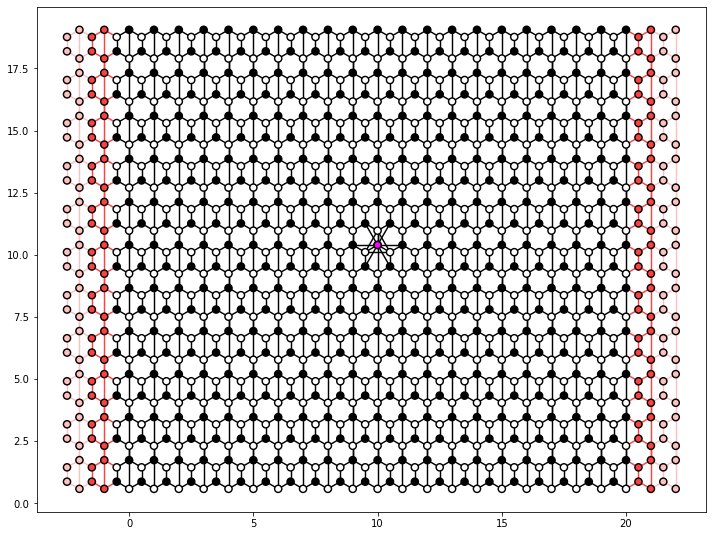

In [85]:
fig, ax = plt.subplots(figsize=(12,12))
ax.set_aspect('equal')
kwant.plot(system_completed, site_color=family_colors, site_lw=0.1, ax=ax);

In [86]:
fsyst_with_adatom = system_completed.finalized()

In [87]:
zero_energy_ldos, finite_energy_ldos = calculate_LDOS(fsyst_with_adatom, Energy=7e-3)

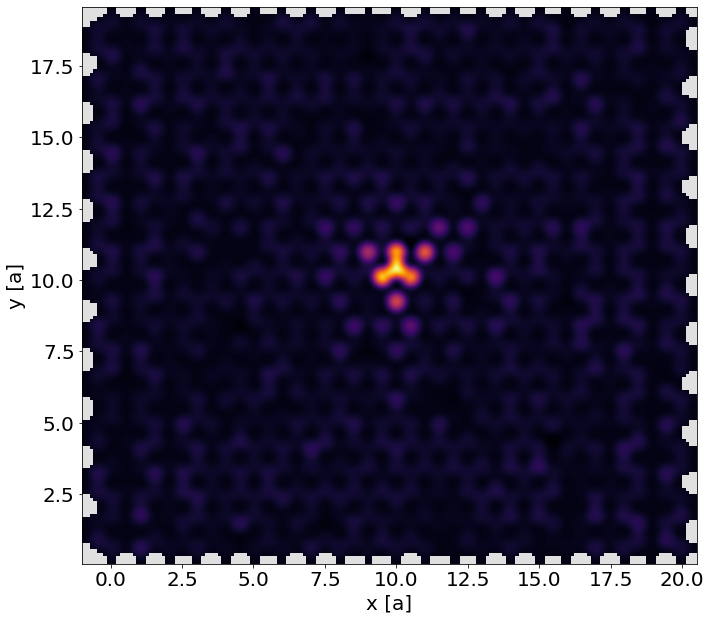

In [88]:
fig, axes = plt.subplots(figsize=(10, 10))
kwant.plotter.density(fsyst_with_adatom, zero_energy_ldos.real, ax=axes, cmap='inferno')
axes.tick_params(labelsize=20)
axes.set_xlabel('x [a]', fontsize=20)
axes.set_ylabel('y [a]', fontsize=20)
axes.set_aspect('equal')
# axes.set_xlim(0,20)
# axes.set_ylim(2,17)
plt.tight_layout()
plt.show()

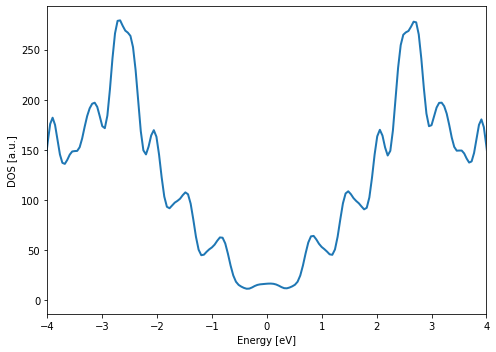

In [98]:
plot_DOS(fsyst_with_adatom)

In [90]:
sites = [s for s in system.sites()]

In [91]:
len(sites)

925

In [92]:
1/925

0.001081081081081081